## County-level Food Insecurity Dataset
- 2017 county-level data on the level of food insecurity
    - https://www.feedingamerica.org/sites/default/files/2019-05/2017-map-the-meal-gap-full.pdf
    - Based on the Current Population Survey Dataset
- Combines food insecurity data with dozens of county-level statistics that may be associated with food insecurity (e.g. income, access to various types of grocery stores, demographics, food prices, etc.)

## Business Case
- The Doritos Foundation has decided that they want to spend their Doritos fortune addressing the most important, impactable elements of food insecurity, and they want to understand what the most crucial factors are underpinning this national issue.
- Based on the most recent data nationally - what three factors should the Doritos Foundation focus its efforts on?

## Goal
- **Evaluate which county-level factors are most closely associated with three classifications of county food insecurity: Very High, High, and Medium / Low**
- We have 67 potential factors at the county level that may drive our observed levels of food insecurity - prioritizing these will be our main outcome



In [54]:
import pandas as pd
import numpy as np
import datetime as dt
import json
np.random.seed(0)
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from xgboost import plot_tree
import xgboost
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image  
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
import pydotplus
import statsmodels.formula.api as smf
import seaborn as sns
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [77]:
#Graphviz import not working

#import os

#os.environ["PATH"] += os.pathsep +"C:\Program Files (x86)\Graphviz2.38\bin\dot.exe"

#os.environ["PATH"] += os.pathsep +"C:\Program Files (x86)\Graphviz2.38\bin"

In [118]:
# Importing Data (needed ISO coding to fix character issue)

df_raw = pd.read_csv('county-food-insecurity-import.csv', encoding = 'ISO-8859-1')

In [82]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141 entries, 0 to 3140
Data columns (total 70 columns):
FIPS                         3141 non-null int64
State                        3141 non-null object
County                       3141 non-null object
Food                         3141 non-null object
Population Estimate, 2016    3141 non-null object
PCT_LACCESS_POP15            3141 non-null float64
PCT_LACCESS_LOWI15           3141 non-null float64
PCT_LACCESS_HHNV15           3141 non-null float64
PCT_LACCESS_SNAP15           3141 non-null float64
PCT_LACCESS_CHILD15          3141 non-null float64
PCT_LACCESS_SENIORS15        3141 non-null float64
PCT_LACCESS_WHITE15          3141 non-null float64
PCT_LACCESS_BLACK15          3141 non-null float64
PCT_LACCESS_HISP15           3141 non-null float64
PCT_LACCESS_NHASIAN15        3141 non-null float64
PCT_LACCESS_NHNA15           3141 non-null float64
PCT_LACCESS_NHPI15           3141 non-null float64
PCT_LACCESS_MULTIR15         314

### Regression Approach
- Before jumping into the machine learning classification methods, lets apply a short version of the regression workflow from module 1 to see the difficulties in sorting through this large / sprawling type of dataset
- Activities:
    - Multivariate regression of all factors vs. our outcome of interest (continuous in this case)
    - Correlation heatmap to see which factors correlate with one another

In [18]:

#Regression alternative
def olsregress(df, outcome_name, list_of_dep_cols, weights):
    """Multiple linear regression function using formula method (takes df, outcome col name, and list of dependent column names)"""
    formula = f'{outcome_name} ~ '
    formula = formula+list_of_dep_cols[0]
    for column in list_of_dep_cols[1:]:
        formula = f'{formula} + {column}'
    result = smf.ols(formula=formula, data=df).fit()
    return result

population = df_raw['Population Estimate, 2016']
dep_varlist = list(df_raw.columns)
drops = ['FIPS ', 'Food', 'State', 'County', 'Population Estimate, 2016']
for item in drops:
    dep_varlist.remove(item)

olsregress(df_raw,'Food', dep_varlist, population).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Food   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     190.4
Date:                Mon, 02 Mar 2020   Prob (F-statistic):               0.00
Time:                        21:11:23   Log-Likelihood:                -6220.2
No. Observations:                3135   AIC:                         1.257e+04
Df Residuals:                    3069   BIC:                         1.297e+04
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                36.3082      4.028      9.014      0.000      28.411      44.206
PCT_LACCESS_POP15        -8.0720      4.474     -1.804      0.071     -16.845       0.701
PCT_LACCESS_LOWI15        0.0728      0.017      4.320      0.000       0.040       0.106
PCT_LACCESS_HHNV15        0.0122      0.018      0.689      0.491      -0.022       0.047
PCT_LACCESS_SNAP15       -0.0434      0.028     -1.572      0.116      -0.097       0.011
PCT_LACCESS_CHILD15      -0.0131      0.041     -0.320      0.749      -0.093       0.067
PCT_LACCESS_SENIORS15     0.0264      0.038      0.693      0.488      -0.048       0.101
PCT_LACCESS_WHITE15       8.0488      4.474      1.799      0.072      -0.724      16.822
PCT_LACCESS_BLACK15       8.0745      4.474      1.805      0.071      -0.698      16.847
PCT_LACCESS_HISP15       -0.0227      0.016     -1.443      0.149      -0.053       0.008
PCT_LACCESS_NHASIAN15     8.0100      4.474      1.790      0.073      -0.762      16.782
PCT_LACCESS_NHNA15        8.0621      4.474      1.802      0.072      -0.711      16.835
PCT_LACCESS_NHPI15        5.5172      4.499      1.226      0.220      -3.305      14.339
PCT_LACCESS_MULTIR15      8.2193      4.474      1.837      0.066      -0.553      16.991
GROCPTH14                -0.0842      0.219     -0.384      0.701      -0.514       0.346
SUPERCPTH14              -0.5328      1.666     -0.320      0.749      -3.799       2.733
CONVSPTH14               -0.0035      0.127     -0.027      0.978      -0.253       0.246
SPECSPTH14               -1.0416      0.480     -2.172      0.030      -1.982      -0.101
SNAPSPTH16                0.0440      0.140      0.315      0.753      -0.230       0.318
WICSPTH12                -1.1266      0.244     -4.616      0.000      -1.605      -0.648
FFRPTH14                  0.8191      0.137      5.972      0.000       0.550       1.088
FSRPTH14                 -0.1034      0.079     -1.308      0.191      -0.258       0.052
REDEMP_SNAPS16         1.057e-06   5.32e-07      1.986      0.047    1.36e-08     2.1e-06
PC_SNAPBEN15              0.0099      0.008      1.297      0.195      -0.005       0.025
PCT_FREE_LUNCH14          0.0021      0.002      0.945      0.345      -0.002       0.007
PCT_REDUCED_LUNCH14       0.0376      0.011      3.562      0.000       0.017       0.058
PC_WIC_REDEMP12          -0.0241      0.005     -4.506      0.000      -0.035      -0.014
REDEMP_WICS12          3.445e-06   8.89e-07      3.874      0.000     1.7e-06    5.19e-06
MILK_PRICE10              5.9355      1.047      5.671      0.000       3.883       7.988
SODA_PRICE10             -2.7421      0.557     -4.922      0.000      -3.834      -1.650
MILK_SODA_PRICE10        -6.4192      0.963     -6.668      0.000      -8.307      -4.532
PC_DIRSALES12          

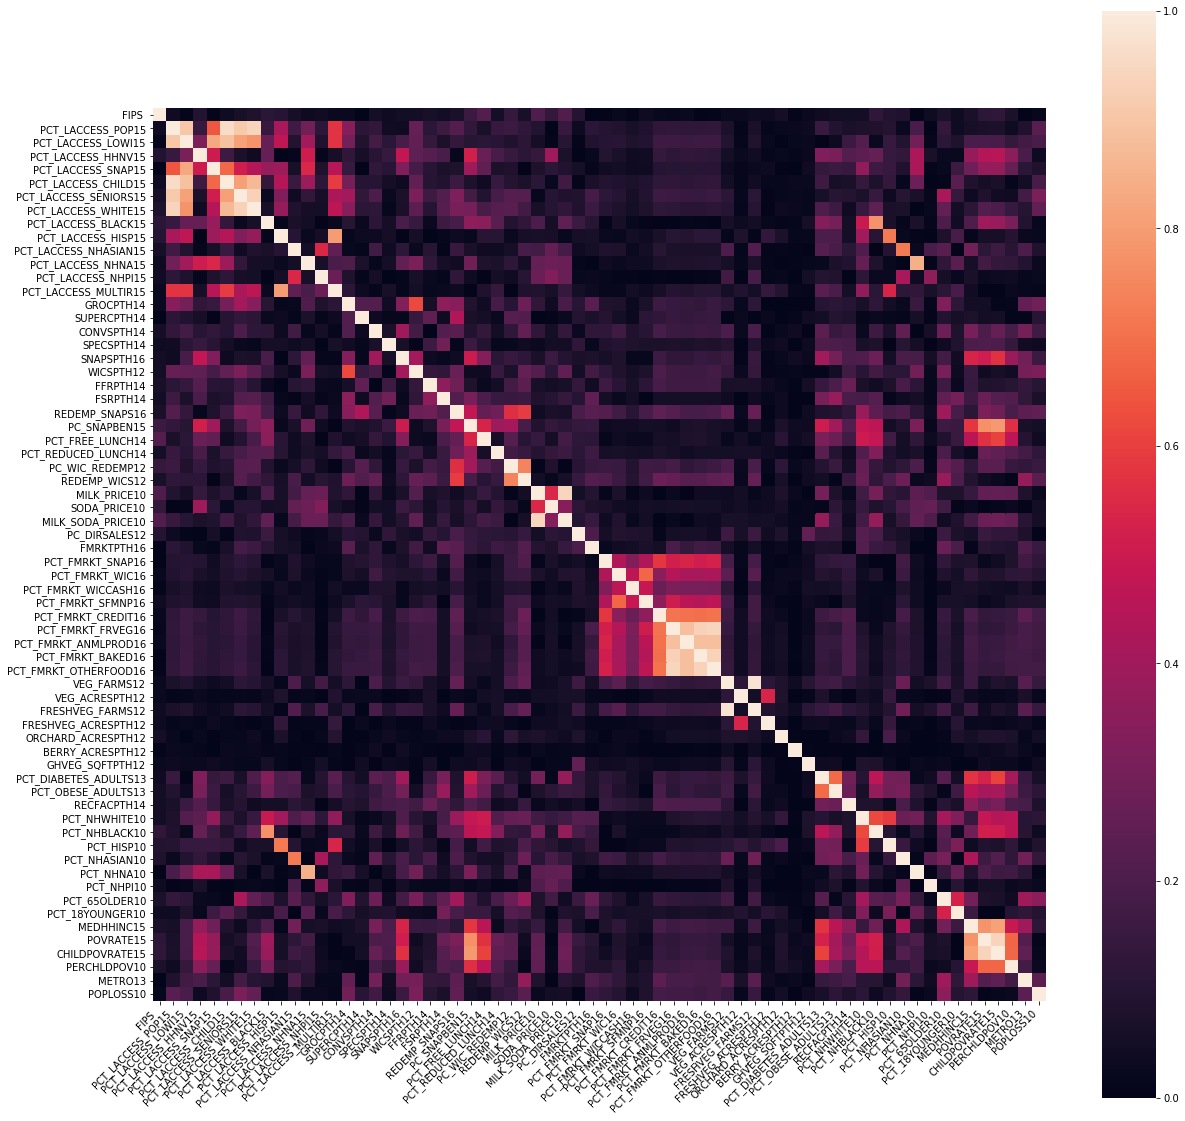

In [85]:
corr = np.abs(df_raw.corr())
plt.figure(figsize=(20,20))
ax = sns.heatmap(
    corr, 
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

## Classifying outcome variable
- Our outcome variable is reported as a continuous value from 0% to 100%, we will recast this outcome variable to have three values, representing the top ~10% most food insecure counties ('V-High' insecurity), the next ~15% most food insecure counties ('High' insecurity), and all other counties.
- We want to see what factors push counties into the High and V-High levels of food insecurity, as these will represent the most important forces.

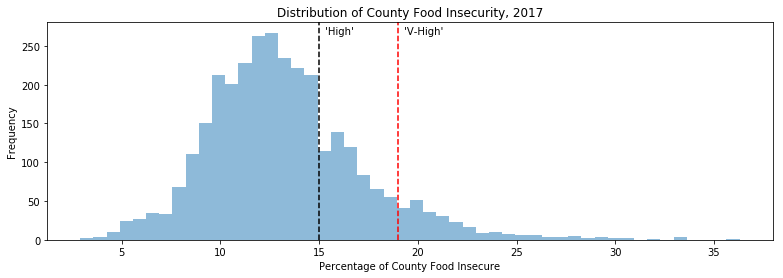

In [119]:
# Recoding Food Output to Categorical

def recode_food(df):
    '''Takes a dataframe with a 'Food' food insecurity percentage column and classifies it into 3 groupings, Low-Mid, High, and V-High'''
    def recode_food_col(x):
        if x < 15:
            return 'Low-Mid'
        if x <19:
            return 'High'
        else:
            return 'V-High'
    df['Food']=df['Food'].apply(recode_food_col)
    return df

ax = df_raw['Food'].plot.hist(bins=50, alpha=0.5, figsize = (13,4))
plt.xlabel('Percentage of County Food Insecure')
plt.title('Distribution of County Food Insecurity, 2017')
ax.axvline(15, color="black", linestyle="--")
plt.text(15.3,265,"'High'")
ax.axvline(19, color="red", linestyle="--")
plt.text(19.3,265,"'V-High'")
plt.show()


In [108]:
df = recode_food(df_raw)

print(df_raw.head())

FIPS      State    County     Food Population Estimate, 2016  \
0   1001   Alabama  Autauga   Low-Mid                    55,416   
1   1003   Alabama  Baldwin   Low-Mid                   208,563   
2   1005   Alabama  Barbour    V-High                    25,965   
3   1007   Alabama     Bibb   Low-Mid                    22,643   
4   1009   Alabama   Blount   Low-Mid                    57,704   

   PCT_LACCESS_POP15  PCT_LACCESS_LOWI15  PCT_LACCESS_HHNV15  \
0              32.06               11.99                3.35   
1              16.77                5.42                1.91   
2              22.11               10.74                4.33   
3               4.23                2.60                2.82   
4               6.50                2.88                3.34   

   PCT_LACCESS_SNAP15  PCT_LACCESS_CHILD15    ...      PCT_NHNA10  PCT_NHPI10  \
0                4.61                 8.46    ...            0.40        0.04   
1                1.30                 3.84    ...    

In [113]:
#Subsetting columns for analysis
df.fillna(df.mean(),inplace = True)
df.describe()

def keep_cols(df, col_list):
    '''Takes a dataframe and list of column names to keep and returns the abridged dataframe'''
    cols_keepdict = {}
    for item in list(df.columns):
        cols_keepdict[item] = 0
    for col in col_list:
        cols_keepdict[col] = 1
    drop = list(df.columns)
    for item in cols_keepdict.keys():
        if cols_keepdict[item] == 1:
            drop.remove(item)
    return df.drop(labels = drop, axis = 1)


In [22]:
def make_xy(df):
    '''Takes a dataframe and returns a dictionary of an x and y train/test randomized 25% splits
    
    Returns:
    tts_dict = {
        'x_train': training df
        'x_test': testing df
        'y_train': training outcome column
        'y_test': testing outcome column
    }

    '''
    pred_cols = list(df.columns)
    pred_cols.remove(outcome_label)
    x = df.loc[:, pred_cols]
    y = df.loc[:, outcome_label]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .25, random_state = 0)
    tts_dict = {}
    tts_dict['x_train'] = x_train
    tts_dict['x_test'] = x_test
    tts_dict['y_train'] = y_train
    tts_dict['y_test'] = y_test
    return tts_dict

def tree_classifier(tts_dict, criterion_input = 'entropy', max_depth_input = 10, min_samples_input = 3):
    '''Takes train/test/split dictionary and tree classifier inptuts, returns a trained model.

    Arguments:
    tts_dict: train/test/split dictionary
    criterion_input : str of criterion (e.g. 'entropy')
    max_depth_input : integer, max tree depth
    min_samples_input: integer, minimum sample size per branch

    Returns:
    Fitted DecisionTreeClassifier object
    ''' 
    clf = DecisionTreeClassifier(criterion = criterion_input, max_depth = max_depth_input, min_samples_split = min_samples_input)
    clf.fit(tts_dict['x_train'], tts_dict['y_train'])
    print('Accuracy: ', 100*round( accuracy_score( tts_dict['y_test'], clf.predict( tts_dict['x_test'])), 4), ' %') 
    return clf

def random_tree_classifier(tts_dict):
    '''Takes train/test/split dictionary and tree classifier inptuts, returns a trained model.

    Arguments:
    tts_dict: train/test/split dictionary

    Returns:
    Fitted RandomForestClassifier object
    ''' 
    clf = RandomForestClassifier(n_estimators = 100)
    clf.fit(tts_dict['x_train'], tts_dict['y_train'])
    print('Accuracy: ', 100*round( accuracy_score( tts_dict['y_test'], clf.predict( tts_dict['x_test'])), 4), ' %')
    return clf 


In [23]:
 def create_confusion_matrix(clf, tts_dict):
    '''Takes two inputs - fitted tree classifier and train/test/split dictionary, returns sklearn confusion matrix'''
    predicted = clf.predict(tts_dict['x_test'])
    results = tts_dict['y_test']
    cm = confusion_matrix(results, predicted, labels = label_list)
    return cm
 
 def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion Matrix',
                          cmap=None,
                          normalize=True):
    """
    Takes a sklearn confusion matrix, and plots it

    Arguments
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: takes list of classification names (same for all graphs)

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cml

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [30]:
print(list(df.columns))

['FIPS ', 'State', 'County', 'Food', 'Population Estimate, 2016', 'PCT_LACCESS_POP15', 'PCT_LACCESS_LOWI15', 'PCT_LACCESS_HHNV15', 'PCT_LACCESS_SNAP15', 'PCT_LACCESS_CHILD15', 'PCT_LACCESS_SENIORS15', 'PCT_LACCESS_WHITE15', 'PCT_LACCESS_BLACK15', 'PCT_LACCESS_HISP15', 'PCT_LACCESS_NHASIAN15', 'PCT_LACCESS_NHNA15', 'PCT_LACCESS_NHPI15', 'PCT_LACCESS_MULTIR15', 'GROCPTH14', 'SUPERCPTH14', 'CONVSPTH14', 'SPECSPTH14', 'SNAPSPTH16', 'WICSPTH12', 'FFRPTH14', 'FSRPTH14', 'REDEMP_SNAPS16', 'PC_SNAPBEN15', 'PCT_FREE_LUNCH14', 'PCT_REDUCED_LUNCH14', 'PC_WIC_REDEMP12', 'REDEMP_WICS12', 'MILK_PRICE10', 'SODA_PRICE10', 'MILK_SODA_PRICE10', 'PC_DIRSALES12', 'FMRKTPTH16', 'PCT_FMRKT_SNAP16', 'PCT_FMRKT_WIC16', 'PCT_FMRKT_WICCASH16', 'PCT_FMRKT_SFMNP16', 'PCT_FMRKT_CREDIT16', 'PCT_FMRKT_FRVEG16', 'PCT_FMRKT_ANMLPROD16', 'PCT_FMRKT_BAKED16', 'PCT_FMRKT_OTHERFOOD16', 'VEG_FARMS12', 'VEG_ACRESPTH12', 'FRESHVEG_FARMS12', 'FRESHVEG_ACRESPTH12', 'ORCHARD_ACRESPTH12', 'BERRY_ACRESPTH12', 'GHVEG_SQFTPTH12', '

Accuracy:  81.67999999999999  %


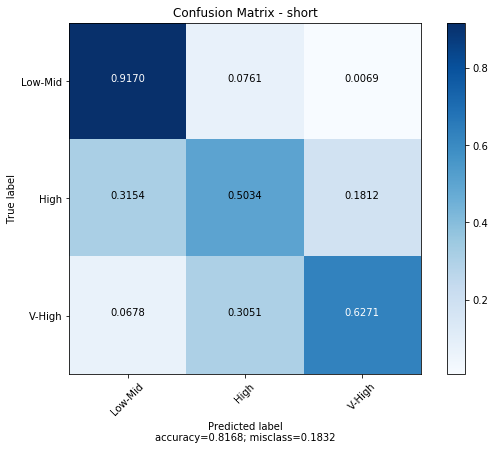

Accuracy:  84.1  %


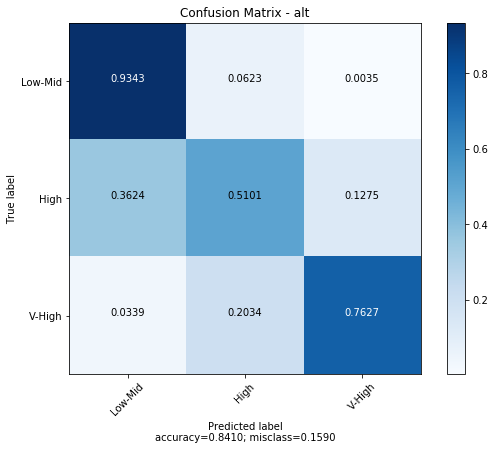

Accuracy:  81.04  %


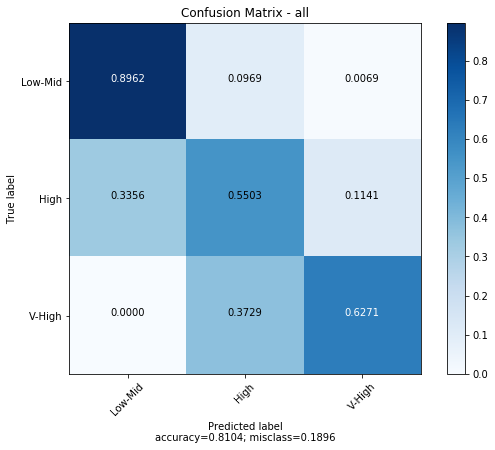

In [114]:
# We always drop a set of county identifiers because they are not predictor values

outcome_label = 'Food'
drops = ['FIPS ', 'State', 'County','Population Estimate, 2016']

# We will compare performance using all columns, to various subset of columns
all_cols = list(df.drop(axis =1, columns = drops).columns)
col_list = ['Food', 'POVRATE15', 'PCT_NHBLACK10', 'PCT_HISP10', 'SPECSPTH14', 'PCT_LACCESS_LOWI15', 'WICSPTH12', 'FFRPTH14', 'MILK_SODA_PRICE10', 'FMRKTPTH16']
col_list_alt = ['Food', 'POVRATE15', 'PCT_NHBLACK10', 'PCT_HISP10', 'MILK_SODA_PRICE10', 'CHILDPOVRATE15', 'PCT_18YOUNGER10','PCT_NHNA10']
col_list_3 = ['Food', 'POVRATE15', 'PCT_NHBLACK10', 'PCT_HISP10', 'MILK_SODA_PRICE10', 'CHILDPOVRATE15', 'PCT_18YOUNGER10','PCT_NHNA10', 'PCT_LACCESS_LOWI15']
col_list_4 = ['Food', 'POVRATE15', 'PCT_NHBLACK10', 'PCT_HISP10', 'MILK_SODA_PRICE10', 'CHILDPOVRATE15', 'PCT_18YOUNGER10','PCT_NHNA10', 'PCT_LACCESS_LOWI15','WICSPTH12','SNAPSPTH16','REDEMP_WICS12']
col_list_5 = ['Food', 'POVRATE15', 'PCT_NHBLACK10', 'PCT_HISP10', 'MILK_SODA_PRICE10', 'CHILDPOVRATE15', 'PCT_18YOUNGER10','PCT_NHNA10', 'PCT_LACCESS_LOWI15','GROCPTH14','SUPERCPTH14','SPECSPTH14','CONVSPTH14']

tts_short = make_xy( keep_cols( df, col_list ))
tts_all = make_xy( keep_cols( df, all_cols ))
tts_alt = make_xy( keep_cols( df, col_list_alt ))
tts_3 = make_xy ( keep_cols( df, col_list_3 ))
tts_4 = make_xy ( keep_cols( df, col_list_4 ))
tts_5 = make_xy ( keep_cols( df, col_list_5 ))

#Tree Classification & Outputs - no input optimization
clf_short = tree_classifier( tts_short )
plot_confusion_matrix(create_confusion_matrix( clf_short, tts_short ),
                          label_list,
                          title='Confusion Matrix - short',
                          cmap=None,
                          normalize=True)

clf_alt = tree_classifier( tts_alt )
plot_confusion_matrix(create_confusion_matrix( clf_alt, tts_alt ),
                          label_list,
                          title='Confusion Matrix - alt',
                          cmap=None,
                          normalize=True)

clf_all = tree_classifier( tts_all )
plot_confusion_matrix(create_confusion_matrix( clf_all, tts_all ),
                          label_list,
                          title='Confusion Matrix - all',
                          cmap=None,
                          normalize=True)


#tree_feature_graph(clf_short, tts_short)
#tree_feature_graph(clf_all, tts_all )
#tree_feature_graph(clf_alt, tts_alt )


In [25]:
def gridsearch_check(tts_dict):
    '''Returns optimal parameters for decision tree classifier given train/test/split data'''
    clf = DecisionTreeClassifier()

    param_grid = {
        'criterion': ['entropy'],
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
        'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    }

    gs_tree = GridSearchCV(clf, param_grid, cv=10)
    gs_tree.fit(tts_dict['x_train'], tts_dict['y_train'])

    return(gs_tree.best_params_)



In [ ]:
print(gridsearch_check(tts_short))

In [163]:
print(gridsearch_check(tts_alt))

{'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 15}


In [173]:
print(gridsearch_check(tts_3))

{'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 4}


In [164]:
print(gridsearch_check(tts_all))

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2}


Accuracy:  82.69999999999999  %
Accuracy:  83.46000000000001  %
Accuracy:  84.22  %
Accuracy:  81.17  %


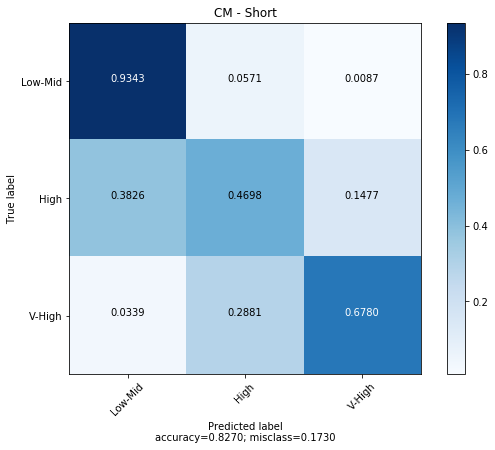

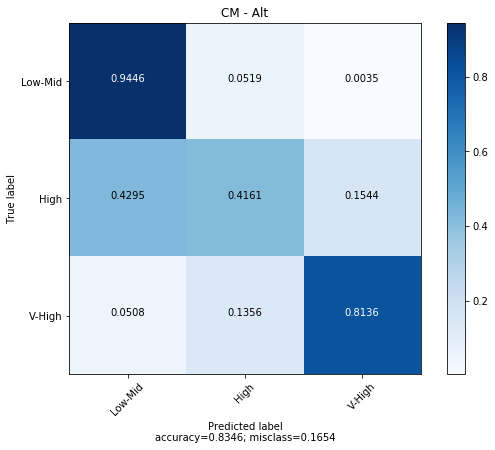

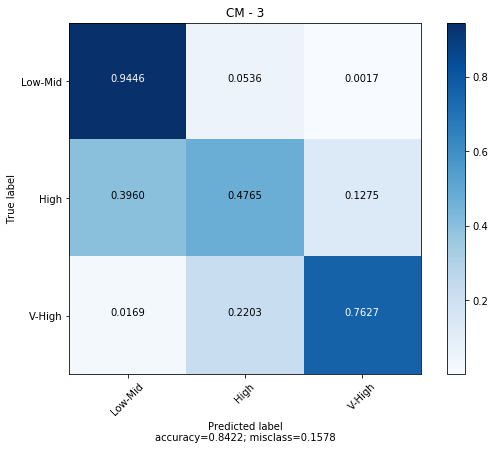

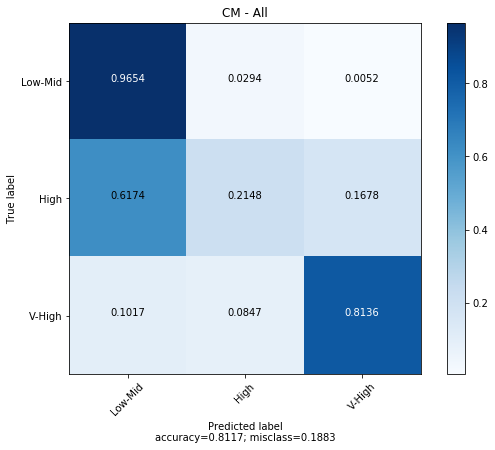

In [33]:
clf_short_optimized = tree_classifier( tts_short , criterion_input = 'entropy', max_depth_input = 7, min_samples_input = 6)
clf_alt_optimized = tree_classifier( tts_alt , criterion_input = 'entropy', max_depth_input = 8, min_samples_input = 15)
clf_3_optimized = tree_classifier( tts_3 , criterion_input = 'entropy', max_depth_input = 11, min_samples_input = 4)
clf_all_optimized = tree_classifier( tts_all , criterion_input = 'entropy', max_depth_input = 4, min_samples_input = 2)

plot_confusion_matrix(create_confusion_matrix( clf_short_optimized, tts_short ),
                          label_list,
                          title='CM - Short',
                          cmap=None,
                          normalize=True)

plot_confusion_matrix(create_confusion_matrix( clf_alt_optimized, tts_alt ),
                          label_list,
                          title='CM - Alt',
                          cmap=None,
                          normalize=True)

plot_confusion_matrix(create_confusion_matrix( clf_3_optimized, tts_3 ),
                          label_list,
                          title='CM - 3',
                          cmap=None,
                          normalize=True)

plot_confusion_matrix(create_confusion_matrix( clf_all_optimized, tts_all ),
                          label_list,
                          title='CM - All',
                          cmap=None,
                          normalize=True)

Accuracy:  86.64  %
Accuracy:  86.00999999999999  %
Accuracy:  85.37  %
Accuracy:  86.13  %


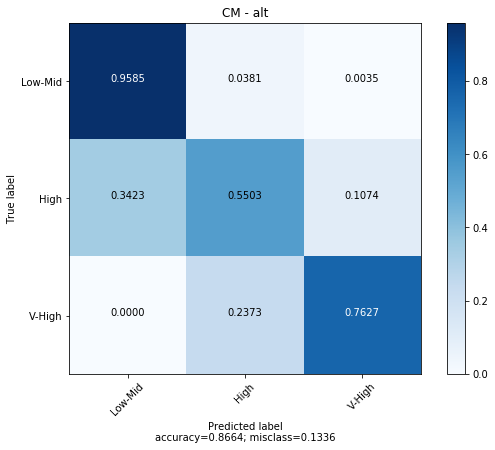

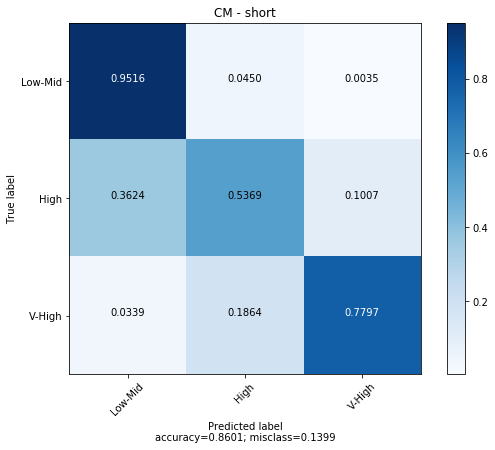

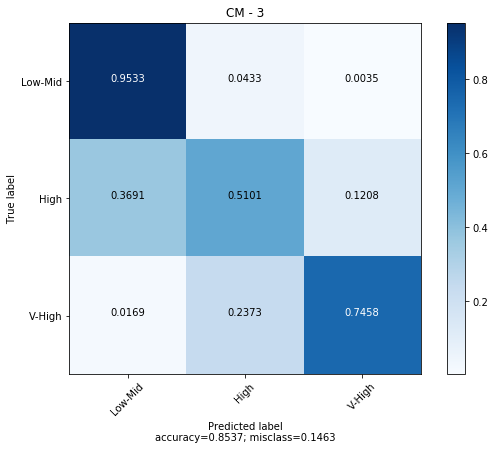

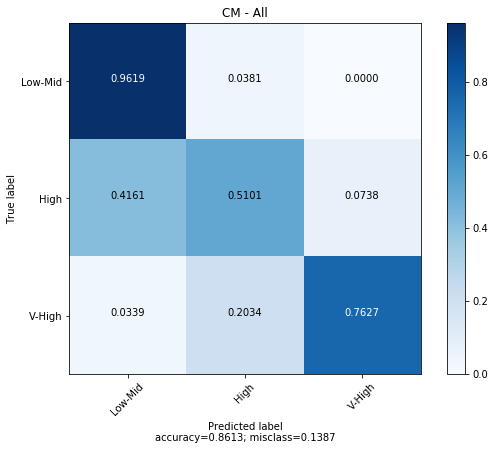

In [34]:
clf_alt_random = random_tree_classifier( tts_alt )
clf_short_random = random_tree_classifier( tts_short )
clf_3_random = random_tree_classifier( tts_3 )
clf_all_random = random_tree_classifier( tts_all )


plot_confusion_matrix(create_confusion_matrix( clf_alt_random, tts_alt ),
                          label_list,
                          title='CM - alt',
                          cmap=None,
                          normalize=True)
plot_confusion_matrix(create_confusion_matrix( clf_short_random, tts_short ),
                          label_list,
                          title='CM - short',
                          cmap=None,
                          normalize=True)
plot_confusion_matrix(create_confusion_matrix( clf_3_random, tts_3 ),
                          label_list,
                          title='CM - 3',
                          cmap=None,
                          normalize=True)

plot_confusion_matrix(create_confusion_matrix( clf_all_random, tts_all ),
                          label_list,
                          title='CM - All',
                          cmap=None,
                          normalize=True)

In [35]:
def xgboost_classifier(tts_dict, learn_rate = 0.1, depth = 5, child_weight = 1, estimators = 100, subs = 0.9):
    '''Returns fitted xgboost_classifier based on four input values'''
    clf = XGBClassifier(learning_rate = learn_rate, max_depth = depth, min_child_weight= child_weight, n_estimators=estimators, subsample=subs)
    clf.fit(tts_dict['x_train'], tts_dict['y_train'])
    print('Accuracy: ', 100*round( accuracy_score( tts_dict['y_test'], clf.predict( tts_dict['x_test'])), 4), ' %')
    return clf 

def gridsearch_xgboost(tts_dict):
    '''Returns optimal parameters given grid of choices for given train/test/split data'''
    clf = XGBClassifier()

    param_grid = {
        'learning_rate': [0.1, 0.2, 0.3],
        'max_depth': [5, 7, 9],
        'min_child_weight': [1, 2, 3],
        'subsample': [0.5, 0.7, 0.9],
        'n_estimators': [100]

    }

    gs_tree = GridSearchCV(clf, param_grid, cv=2)
    gs_tree.fit(tts_dict['x_train'], tts_dict['y_train'])

    return(gs_tree.best_params_)

In [197]:
print(gridsearch_xgboost(tts_alt ))

{'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


In [201]:
print(gridsearch_xgboost(tts_all ))

{'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


In [38]:
print(gridsearch_xgboost(tts_3 ))

{'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


In [39]:
print(gridsearch_xgboost(tts_short ))

{'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}


Accuracy:  86.26  %


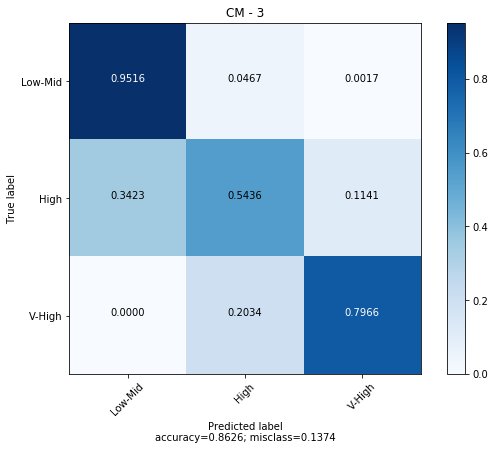

In [36]:
clf_xgb_alt = xgboost_classifier(tts_alt, learn_rate = 0.1, depth = 5, child_weight = 1, estimators = 100, subs = 0.9)
plot_confusion_matrix(create_confusion_matrix( clf_xgb_alt, tts_alt ),
                          label_list,
                          title='CM - alt',
                          cmap=None,
                          normalize=True)

Accuracy:  86.39  %


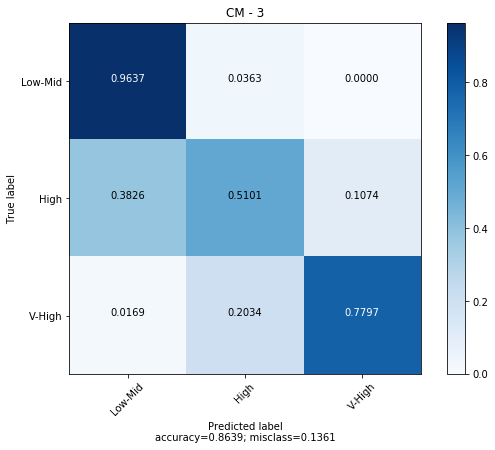

In [37]:
clf_xgb_all = xgboost_classifier(tts_all, learn_rate = 0.1, depth = 7, child_weight = 3, estimators = 100, subs = 0.9)
plot_confusion_matrix(create_confusion_matrix( clf_xgb_all, tts_all ),
                          label_list,
                          title='CM - All',
                          cmap=None,
                          normalize=True)

Accuracy:  86.39  %


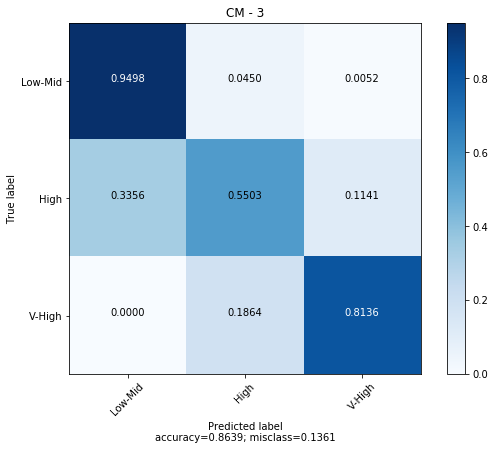

In [47]:
clf_xgb_3 = xgboost_classifier(tts_3, learn_rate = 0.1, depth = 5, child_weight = 1, estimators = 100, subs = 0.9)
plot_confusion_matrix(create_confusion_matrix( clf_xgb_3, tts_3 ),
                          label_list,
                          title='CM - 3',
                          cmap=None,
                          normalize=True)

Accuracy:  85.5  %


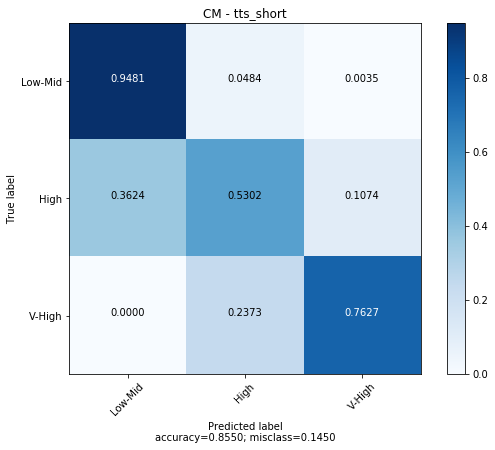

In [48]:
clf_xgb_short = xgboost_classifier(tts_short, learn_rate = 0.1, depth = 5, child_weight = 2, estimators = 100, subs = 0.9)
plot_confusion_matrix(create_confusion_matrix( clf_xgb_short, tts_short ),
                          label_list,
                          title='CM - tts_short',
                          cmap=None,
                          normalize=True)

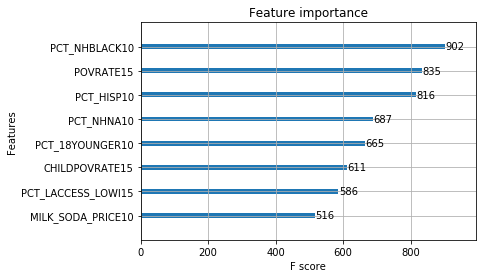

In [58]:
xgboost.plot_importance(clf_xgb_3, importance_type = 'weight')

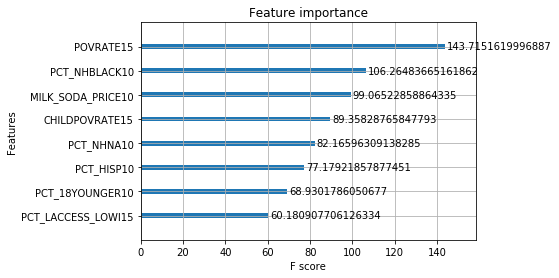

In [56]:
xgboost.plot_importance(clf_xgb_3, importance_type = 'cover')

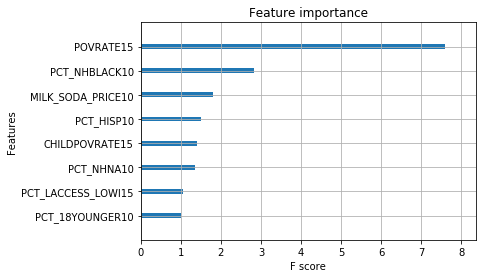

In [120]:
xgboost.plot_importance(clf_xgb_3, importance_type = 'gain', show_values=False)

Accuracy:  86.39  %


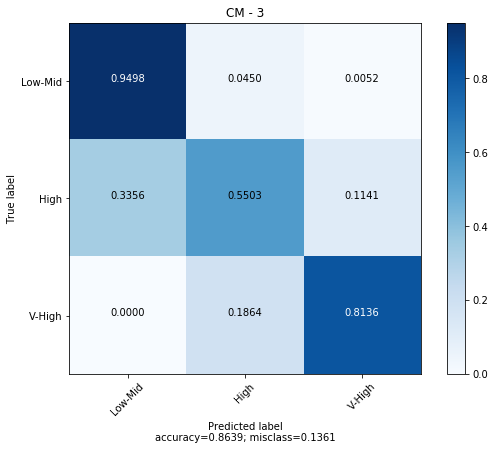

Accuracy:  86.64  %


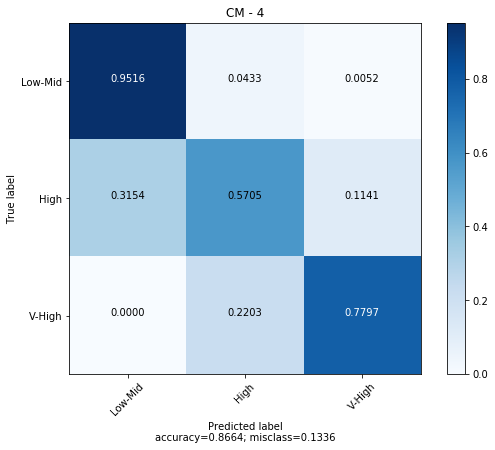

Accuracy:  86.39  %


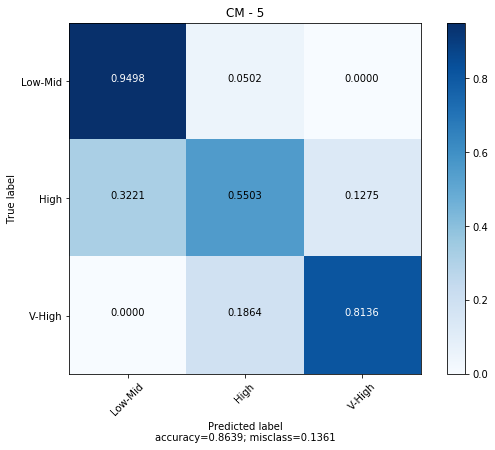

In [122]:
clf_xgb_3 = xgboost_classifier(tts_3, learn_rate = 0.1, depth = 5, child_weight = 1, estimators = 100, subs = 0.9)
plot_confusion_matrix(create_confusion_matrix( clf_xgb_3, tts_3 ),
                          label_list,
                          title='CM - 3',
                          cmap=None,
                          normalize=True)

clf_xgb_4 = xgboost_classifier(tts_4, learn_rate = 0.1, depth = 5, child_weight = 1, estimators = 100, subs = 0.9)
plot_confusion_matrix(create_confusion_matrix( clf_xgb_4, tts_4 ),
                          label_list,
                          title='CM - 4',
                          cmap=None,
                          normalize=True)

clf_xgb_5 = xgboost_classifier(tts_5, learn_rate = 0.1, depth = 5, child_weight = 1, estimators = 100, subs = 0.9)
plot_confusion_matrix(create_confusion_matrix( clf_xgb_5, tts_5 ),
                          label_list,
                          title='CM - 5',
                          cmap=None,
                          normalize=True)

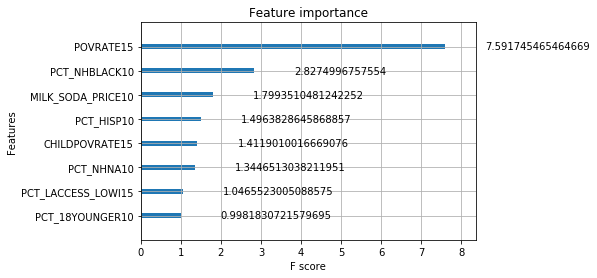

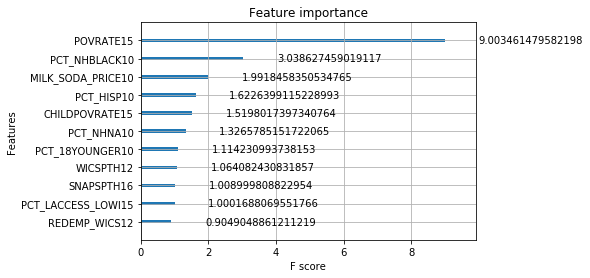

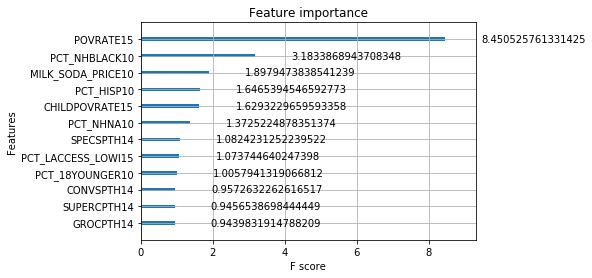

In [116]:
xgboost.plot_importance(clf_xgb_3, importance_type = 'gain')
xgboost.plot_importance(clf_xgb_4, importance_type = 'gain')
xgboost.plot_importance(clf_xgb_5, importance_type = 'gain')

## Conclusion:
#### Methods:
- Our most successful classification method, the XGBoost gradient boosting decision tree model, was more than 86% accurate at classifying counties into Very High, High, or Medium-Low food insecurity categorizations.
    - Notably, the most successful model used a subset of just 9 columns to produce results more accurate at classification than measures using all columns
    - Variables included were race, relative price of milk to soda, poverty level, and rate of low access to food and low income
    - Adding variables to this core set of 9 predictors generally did not increase accurace, but often would trade off accuracey of predicting very-high food insecure areas for increased accuracy at high food insecurity areas

### Results:
- Consistently, across methods and predictor groupings, the most powerful predictors in order (based on contributed gain in the decision tree model):
    - **Poverty rate**: far and above the most important predictor of whether a county faces food insecurity, even controlling for the rate of WIC, WIC redemptions, and SNAP usage, this was a crucial factor
    - **Race**: counties with higher proportions of black or hispanic residents faced significantly higher food insecurity, even controlling for the poverty rate and other factors.  
    - ** Food Prices **: our dataset offered a metric, the ratio of milk prices to soda prices, which seeks to get at the relative price premium of perishable food to soda, and this was the third most impactful feature in the dataset, ahead of a measure of low access to food, WIC / SNAP usage, or the per-capita presence of grocery, convenience, or specialty stores in a county

## Recommendations:

The Doritos Foundation should focus efforts on three key areas: economic stimulation, food price relief, and population-specific efforts.  
    -**Economic Stimulus**: in this analysis, the most important hurdle is reducing the number of residents in a county under the poverty level.  This is a highly complex issue, but approaches such as the earned-income tax credit (EITC), job training programs, and increases in the minimum wage may be appropriate in some of these counties  
    -**Perishable Food Pricing**: An under-examined metric is the relative price of perishable food like milk to unperishable food like soda. Often the metric of choice for describing food inaccessibility is the actual physical lack of grocery or specialty stores in a region, however this analysis suggests that actual price is a more important indicator than physical dispersion of stores.  This factor needs more analysis to determine whether prices are driven by scarcity, lack of distribution networks, or other explanations.  
    -**Race**: The fact that race is so consistently a key explanatory factor in this analysis indicats that there is a need for the Foundation to invest in additional initiatives that support food insecurity within black and hispanic communities in order to bridge the gap in food insecurity that these groups face relative to other communities.

In [ ]:
# Decision Surface Plot For Subset of Features

# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02


for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")

plt.figure()
clf = DecisionTreeClassifier().fit(iris.data, iris.target)
plot_tree(clf, filled=True)
plt.show()


In [ ]:
def tree_feature_graph(clf, tts_dict):
    n_features = tts_dict['x_train'].shape[1]
    plt.figure(figsize=(8,16))
    plt.barh(range(n_features), clf.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), tts_dict['x_train'].columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

def dot_graph(clf, tts_dict):
    dot_data = export_graphviz(clf, out_file = None, feature_names = x_train.columns, class_names = np.unique(tts_dict['y_train']).astype('str'), filled = True, rounded = True, special_characters = True)

    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    pydot_graph.set_size('"30,30!"')
    pydot_graph.write_png('tree_output.png')  

label_list = ['Low-Mid', 'High', 'V-High']

